# Determine which pairs of mutated positions are linked, and plot results

**Part 2 of the "linked mutations" analyses.**

In [1]:
%run "Header.ipynb"

In [2]:
import pickle
import shutil
import subprocess
import networkx as nx
from itertools import combinations
from parse_sco import parse_sco
from linked_mutations_utils import (
    MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE, emptyListOf4
)

N = 10

## Using the computed groups...

### Plot $|Reads(i, j)|$ vs. $\big(|Reads(i, -)| + |Reads(-, j)|\big)$

Minor considerations, based on how this data was computed in the first linked mutations notebook:

- We have already excluded mutated positions with less than some min coverage (current value is 1,000x).
- We have already excluded pairs more than some distance away from each other (current value is set in the config file; it might be infinity, in which case there effectively isn't a limit).
  - (Note that we do allow for pairs to span the start/end of the genome.)
  
We could also subset these pairs to just "consecutive" ones; however, doing that while allowing for pairs to span the start/end of the genome is tricky, so for simplicity's sake we just show all (potentially) valid pairs here.

On seq edge_6104.
....................................................................................................
Done with edge_6104!

On seq edge_1671.
....................................................................................................
Done with edge_1671!

On seq edge_2358.
....................................................................................................
Done with edge_2358!


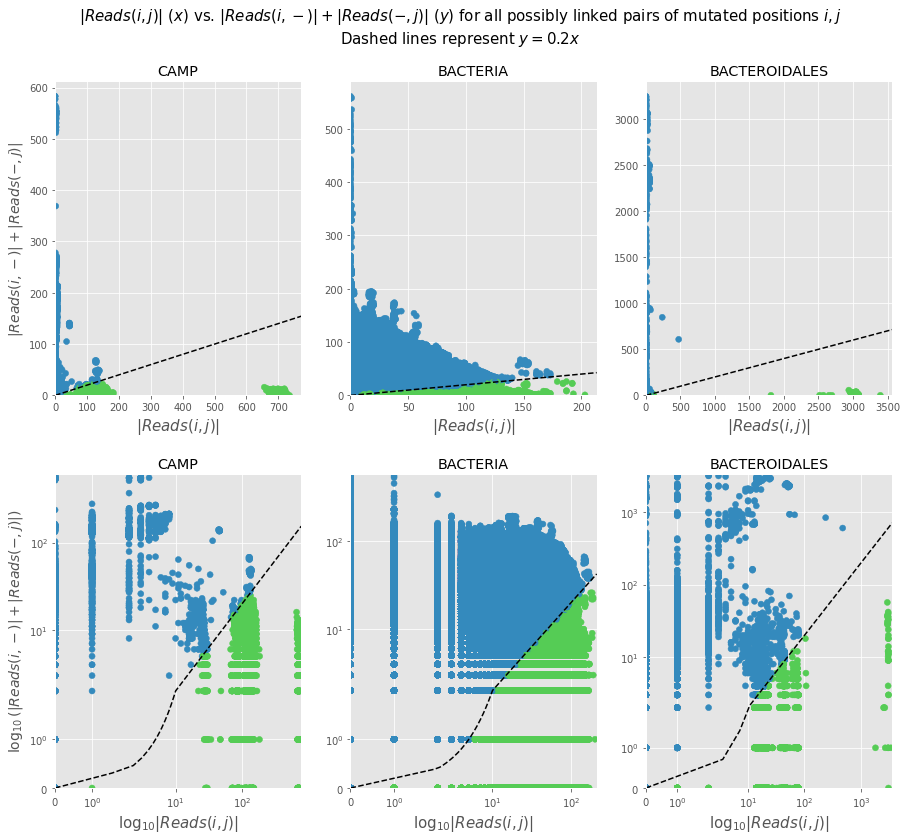

In [10]:
fig, axes = pyplot.subplots(2, 3, gridspec_kw={"hspace": 0.25})
for i, seq in enumerate(SEQS):
    print(f"On seq {seq}.")
    with open(f"pospair2groupcts/{seq}_pospair2groupcts.pickle", "rb") as pf:
        pospair2groupcts = pickle.load(pf)
    
    axNonLog = axes[0, i]
    axLog = axes[1, i]
    
    onehundredth = round(len(pospair2groupcts) / 100)
    plotx = []
    ploty = []
    plotcolor = []
    for ii, pospair in enumerate(sorted(pospair2groupcts.keys()), 1):
        
        # Crude progress bar.
        # This might occasionally print 99 or 101 dots instead of 100 dots per genome, but this is reasonable
        # enough. Just to reassure myself that this hasn't crashed my laptop.
        if ii % onehundredth == 0:
            print(".", end="")
            
        cts = pospair2groupcts[pospair]

        # Color pairs that are less than the 0.2 threshold specially (this is the remaining condition
        # for these pairs being linked, although we could also have non-consecutive mutations be linked
        # since the pairs we draw here are just a subset of the total pairs)
        if (cts[1] + cts[2]) < MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * cts[0]:
            color = "#55cc55"
        else:
            color = SCATTERPLOT_PT_COLOR

        plotx.append(cts[0])
        ploty.append(cts[1] + cts[2])
        plotcolor.append(color)
            
    # Building up a list of x/y/color values, and then plotting that, is A TON faster than plotting each
    # point individually (like, calling ax.scatter() for each point). Hence why we do it here!
    # There are some other notebooks in this repo that do things the other way (e.g. as of writing the
    # "within-gene" plots plot each point individually) -- but those plots usually have at most a few thousand
    # points per plot, so it's not anywhere near as big a deal as it is here.
    axNonLog.scatter(plotx, ploty, c=plotcolor)
    axLog.scatter(plotx, ploty, c=plotcolor)
    print(f"\nDone with {seq}!")
    if i < 2:
        print("\n", end="")
    if i == 0:
        axNonLog.set_ylabel("$|Reads(i, -)| + |Reads(-, j)|$", fontsize=14)
        axLog.set_ylabel("$\log_{10} \, (|Reads(i, -)| + |Reads(-, j)|)$", fontsize=14)
        
    axNonLog.set_xlabel("$|Reads(i, j)|$", fontsize=15)
    axLog.set_xlabel("$\log_{10} |Reads(i, j)|$", fontsize=15)
        
    # Bound the left and bottom of each scatterplot at x = 0 and y = 0
    axNonLog.set_xlim(0)
    axNonLog.set_ylim(0)
    axLog.set_xlim(0)
    axLog.set_ylim(0)
    
    # Plot the line y = (MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE) * x
    # Represents the cutoff point for when or not we consider a pair of mutated positions to be linked.
    # Based on https://stackoverflow.com/a/43811762.
    xvals = axNonLog.get_xlim()
    yvals = [MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * x for x in xvals]
    axNonLog.plot(xvals, yvals, "--", c="#000000")
    
    # Approximate the same line in the log plot. Just connect 
    maxx = max(axLog.get_xlim())
    dx = maxx / 1000
    lxvals = [dx * d for d in range(1001)]
    lyvals = [MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * x for x in lxvals]
    axLog.plot(lxvals, lyvals, "--", c="#000000")
    
    axLog.set_xscale("symlog")
    axLog.set_yscale("symlog")
    
    axNonLog.set_title(seq2name[seq])
    axLog.set_title(seq2name[seq])
    
fig.suptitle(
    (
        "$|Reads(i, j)|$ ($x$) vs. $|Reads(i, -)| + |Reads(-, j)|$ ($y$) for all possibly linked pairs of mutated positions $i, j$\n"
        f"Dashed lines represent $y = {MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE:.1f}x$"
    ),
    fontsize="15",
    y=0.96
)
fig.set_size_inches(15, 13)
fig.savefig("figs/readsij_scatterplots.png", bbox_inches="tight")

## Define mutated positions as "linked" or not, and then create a graph for each genome

__Nodes:__ Mutated positions.

__Edges:__ Connect _linked_ mutated positions.

In [3]:
seq2graph = {}
for i, seq in enumerate(SEQS):
    g = nx.Graph()
    print(f"On seq {seq}...", end=" ")
    with open(f"pospair2groupcts/{seq}_pospair2groupcts.pickle", "rb") as pf:
        pospair2groupcts = pickle.load(pf)
        
    # Adding the same node twice doesn't hurt, so the lazy approach is ok
    # (not calling find_mutated_positions() from the utils file since that requires loading some big
    # JSONs into memory which will bork my laptop)
    for pair in pospair2groupcts:
        # The positions in pospair2groupcts are 0-indexed. To make working with gene data/etc. easier, convert
        # to 1-indexing.
        g.add_node(pair[0] + 1)
        g.add_node(pair[1] + 1)
        
        cts = pospair2groupcts[pair]
        if (cts[1] + cts[2]) < MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * cts[0]:
            g.add_edge(pair[0] + 1, pair[1] + 1)
    
    seq2graph[seq] = g
    print("Created graph!")

On seq edge_6104... Created graph!
On seq edge_1671... Created graph!
On seq edge_2358... Created graph!


## Graph stats: what are the sizes of the $N$ largest components?

($N$ was defined at the top of this notebook, fyi)

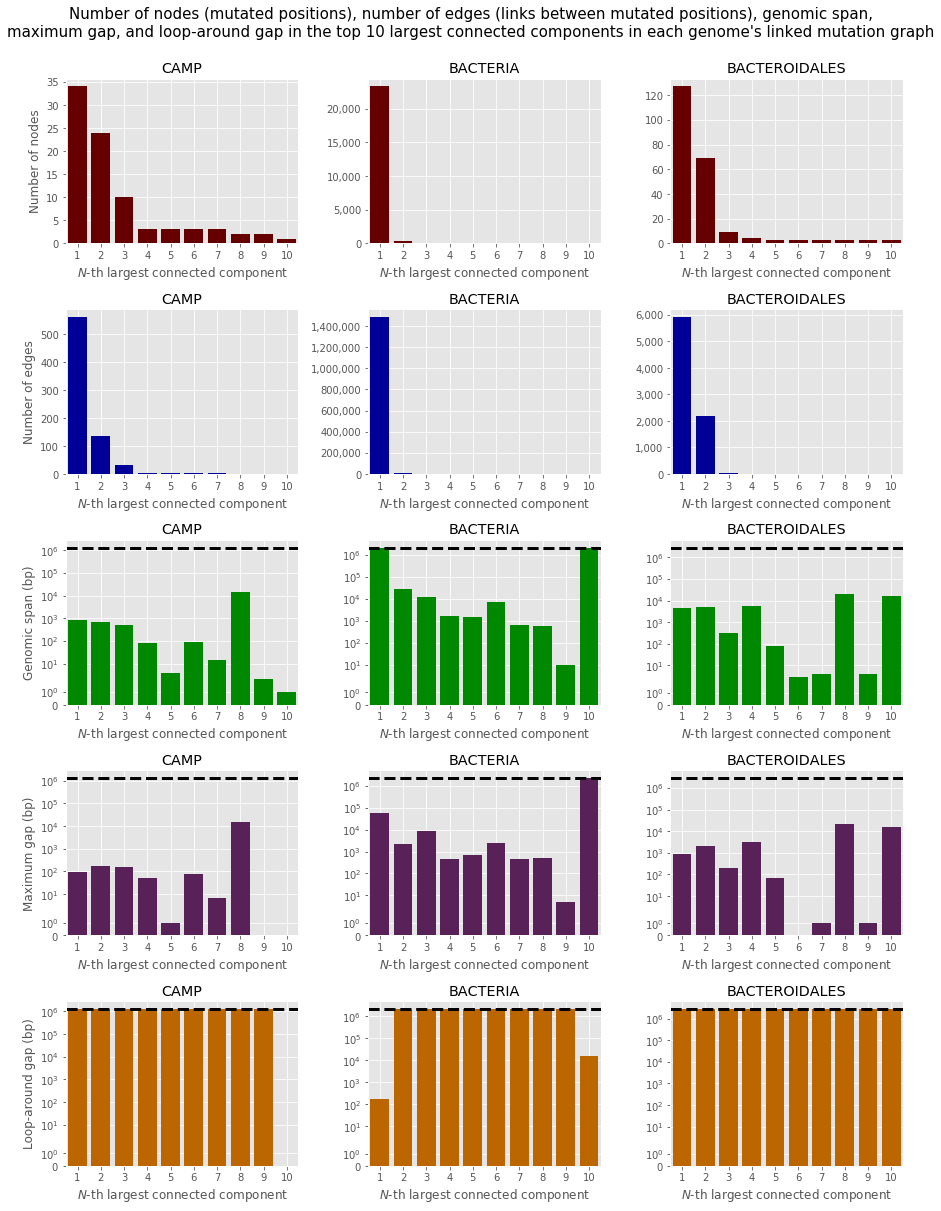

In [4]:
seq2topN_cc_subgraphs = {}
seq2sorted_cc_node_lists = {}

gfig, gaxes = pyplot.subplots(5, 3, gridspec_kw={"hspace": 0.4, "wspace": 0.3})
for i, seq in enumerate(SEQS):
    g = seq2graph[seq]
    
    # nx.connected_components() returns a list of lists, where each inner list is just the nodes in
    # a given component.
    ccs = nx.connected_components(g)
    
    # Sort the connected component lists in descending order by number of nodes, and filter to the N ccs
    # with the largest #s of nodes (breaking ties arbitrarily)
    sorted_ccs = sorted(ccs, key=lambda cc: len(cc), reverse=True)
    topN_ccs = sorted_ccs[:N]
    seq2sorted_cc_node_lists[seq] = sorted_ccs
    
    topN_ccnodects = [len(cc) for cc in topN_ccs]
    
    # Induce subgraphs for each of the top N components
    cc_subgraphs = [g.subgraph(cc) for cc in topN_ccs]
    seq2topN_cc_subgraphs[seq] = cc_subgraphs
    
    # To figure out the number of edges in this component, just look at the number of edges in the
    # corresponding subgraph
    topN_ccedgects = [len(subg.edges) for subg in cc_subgraphs]
    
    # Figure out spans of each component
    topN_ccspans = [max(subg.nodes) - min(subg.nodes) + 1 for subg in cc_subgraphs]
    
    # Figure out max gaps and looparounds for each component
    topN_ccmaxgaps = []
    topN_cclooparounds = []
    for scci, subg in enumerate(cc_subgraphs, 1):
        max_gap = 0
        looparound = 0
        if len(subg.nodes) > 1:
            snodes = sorted(subg.nodes)
            
            for ni, p1 in enumerate(snodes[:-1]):
                # the -1 makes sure that this range is perfectly exclusive: neither p1 nor p2 are included
                # in the gap between them, whereas the span purposefully _includes_ both the rightmost and
                # leftmost positions. It doesn't make a huge difference, but the devil is in the details.
                gap = snodes[ni + 1] - p1 - 1
                max_gap = max(max_gap, gap)
                
            # Looparounds -- we define this for all seqs (so, including CAMP/edge_6104), not just the two
            # circular ones.
            looparound = seq2len[seq] + snodes[0] - snodes[-1] - 1

        topN_ccmaxgaps.append(max_gap)
        topN_cclooparounds.append(looparound)
    
    axN = gaxes[0, i]
    axN.bar(range(1, N + 1), topN_ccnodects, color="#660000")
    
    axE = gaxes[1, i]
    axE.bar(range(1, N + 1), topN_ccedgects, color="#000099")
    
    axS = gaxes[2, i]
    axS.bar(range(1, N + 1), topN_ccspans, color="#008800")
    
    axG = gaxes[3, i]
    axG.bar(range(1, N + 1), topN_ccmaxgaps, color="#582258")
    
    axL = gaxes[4, i]
    axL.bar(range(1, N + 1), topN_cclooparounds, color="#BB6600")
    
    if i == 0:
        axN.set_ylabel("Number of nodes")
        axE.set_ylabel("Number of edges")
        axS.set_ylabel("Genomic span (bp)")
        axG.set_ylabel("Maximum gap (bp)")
        axL.set_ylabel("Loop-around gap (bp)")
        #axS.set_ylabel("Genomic span:\nrightmost - leftmost + 1")
        #axG.set_ylabel("Maximum gap:\nmax(|$p_1 - p_2$| - 1) for all\nadjacent $p_1$, $p_2$ in sorted order")
        #axL.set_ylabel("Loop-around gap:\n gap from rightmost to leftmost,\nlooping around the genome")
       
    for ax in (axN, axE, axS, axG, axL):
        ax.set_title(seq2name[seq])
        ax.set_xlabel("$N$-th largest connected component")
        use_thousands_sep(ax.get_yaxis())
        ax.set_xlim(0.5, N + 0.5)
        # Based kind of on https://stackoverflow.com/a/28289136
        ax.set_xticks(range(1, N + 1))
        
    for ax in (axS, axG, axL):
        ax.axhline(y=seq2len[seq], linestyle="--", color="black", linewidth=3,
                    label=f"{seq2name[seq]} length: {seq2len[seq]:,} bp")
        ax.set_yscale("symlog")
        ax.margins(y=0.05)
        
gfig.suptitle(
    (
        "Number of nodes (mutated positions), number of edges (links between mutated positions), "
        f"genomic span,\nmaximum gap, and loop-around gap in the top {N} largest connected components "
        "in each genome's linked mutation graph"
    ),
    fontsize="15",
    y=0.93
)
gfig.set_size_inches(15, 20)
gfig.savefig(f"figs/linkedmutgraph_top{N}cc_stats.png", bbox_inches="tight")

## Create Graphviz DOT files for the top $N$ largest components, coloring nodes by gene

We don't convert the DOT files to PNG yet, since that can take a while.

In [53]:
def get_parent_gene_info_of_position(pos, genes_df):
    """Returns information about the parent gene(s) of a position.
    
    Parameters
    ==========
    
    pos: int
        1-indexed position in a genome.
        
    genes_df: pd.DataFrame
        Result from calling parse_sco().
        
    Returns
    =======
    
    parent_info: one of (int, str, None)
        If this position only has one parent gene, returns an integer corresponding to the
        gene number in the Prodigal .SCO file. This is 1-indexed, so the first gene is numbered 1.
        
        If this position has multiple parent genes (due to gene overlap),
        returns the string "Multiple".
        
        If this position has no parent genes (due to this position being located in a non-coding
        region of the genome), returns None.
        
        "Statically typed programming languages are for chumps" -- charles darwin idk
    """
    parent_gene = None
    for gene in genes_df.itertuples():
        if pos >= int(gene.LeftEnd) and pos <= int(gene.RightEnd):
            if parent_gene is None:
                parent_gene = int(gene.Index)
            else:
                return "Multiple"
    return parent_gene

def get_gv_preamble(numnodes, use_prism=True):
    out_gv = " {\n"
    
    # DON'T use prism when using circo -- it causes weird things to happen to the graph layout, far as I
    # can tell. Like, it makes complete graphs look like these weird elliptical shapes instead of just
    # circles (case in point: CAMP cc1 as of writing)
    if use_prism:
        # Spend extra time trying to reduce node overlap
        out_gv += '\toverlap="prism50";\n'
    
    # Draw edges below nodes, so that it's easier to see all nodes (prevents occlusion of nodes by edges)
    out_gv += '\toutputorder="edgesfirst";\n'
    
    out_gv += '\tnode [style="filled"];\n'
    
    # Only add a label for graphs with < 1000 nodes. Past that, the labels will inflate the
    # file size and mess with the image when viewed at low resolution, so we don't bother adding a
    # label. (The default in Graphviz is for nodes to have labels -- see
    # http://www.graphviz.org/doc/info/attrs.html#d:label.)
    if numnodes >= 1000:
        out_gv += '\tnode [label=""];\n'
        
    # Lower the resolution of extra-large graphs to make it feasible to embed, e.g., the really big
    # BACTERIA component in the paper. See https://stackoverflow.com/a/3918019.
    if numnodes >= 1000:
        out_gv += "\tdpi=5;\n"
        
    return out_gv

for seq in SEQS:
    genes_df = parse_sco("../seqs/genes/{}.sco".format(seq))
    
    num_genes = len(genes_df.index)
    
    # Get a quantitative color map, set up in such a way that there are G distinct colors sampled
    # along this color map from low to high (given G genes for a sequence). We'll assign each gene
    # a unique color from this map. See
    # https://matplotlib.org/3.1.1/tutorials/colors/colormap-manipulation.html
    cmap = matplotlib.cm.get_cmap("viridis", num_genes)
    hexcolors = [matplotlib.colors.to_hex(cmap(c)) for c in range(num_genes)]
    
    assert hexcolors[0] == "#440154"
    assert hexcolors[-1] == "#fde725"
    assert len(hexcolors) == num_genes
        
    total_seq_graph_gv = f"graph {seq}"
    total_seq_graph_num_nodes = sum([len(cc) for cc in seq2sorted_cc_node_lists[seq][:10]])
    print(seq, total_seq_graph_num_nodes, "nodes in the top 10 largest ccs")
    total_seq_graph_gv += get_gv_preamble(total_seq_graph_num_nodes)
    
    for cci in range(N):
        
        subg = seq2topN_cc_subgraphs[seq][cci]
        
        numnodes = len(subg.nodes)
        numedges = len(subg.edges)
        span = max(subg.nodes) - min(subg.nodes) + 1
        print(f"{seq2name[seq]}, cc {cci + 1}, {numnodes} nodes, {numedges} edges, {span} bp span")
        
        graph_id = f"{seq2name[seq]}_cc{cci + 1}"
        gv = f"graph {graph_id}"
        
        if seq2name[seq] == "CAMP" and cci == 0:
            use_prism = False
        else:
            use_prism = True
            
        gv += get_gv_preamble(numnodes, use_prism=use_prism)
        
        # If we're not using prism to reduce overlap stuff, then that means we're using circo to lay out
        # CAMP cc1. In this case, we should use mindist=0 to reduce gaps between nodes (and thereby decrease
        # the PNG's dimensions and filesize).
        if not use_prism:
            gv += "\tmindist=0;\n"
        
        # Add a nice label to each graph! https://stackoverflow.com/a/11594722
        # (only do this if the graph is small enough for the label to [probably] be legible)
        if numnodes < 1000:
            gv += f'\tlabel="{seq2name[seq]}, component {cci + 1}: {numnodes:,} nodes, {numedges:,} edges, {span:,} bp span";\n'
            gv += '\tlabelloc="t";\n'
            gv += '\tfontsize=24;\n'
                
        for n in subg.nodes:
            parent_gene_info = get_parent_gene_info_of_position(n, genes_df)
            fontcolor = "#000000"
            if parent_gene_info is None:
                # Not-in-any-genes color is white (no overlap with viridis)
                genecolor = "#ffffff"
            elif parent_gene_info == "Multiple":
                # In-mulitple-genes color is gray (no overlap with viridis)
                genecolor = "#888888"
                # Just for debugging
                print(f"For reference: pos {n} in multiple genes in seq {seq2name[seq]}")
            else:
                # Nice! This position is unique to one gene.
                genecolor = hexcolors[(parent_gene_info - 1)]
                # Color the font white to contrast with darker colors.
                if (parent_gene_info / num_genes) < 0.5:
                    fontcolor = "#ffffff"
                assert parent_gene_info > 0
                
            declbase = f'\t"{n:,}" [fillcolor="{genecolor}"'
            if numnodes < 1000:
                nodedecl = f'{declbase}, fontcolor="{fontcolor}"];\n'
            else:
                nodedecl = f'{declbase}];\n'
                
            gv += nodedecl
            total_seq_graph_gv += nodedecl
            
        for e in subg.edges:
            edgedecl = f'\t"{e[0]:,}" -- "{e[1]:,}";\n'
            gv += edgedecl
            total_seq_graph_gv += edgedecl
            
        gv += "}"
        fnbase = f"graphs/{graph_id}"
        with open(fnbase + ".gv", "w") as ccgraphgvfile:
            ccgraphgvfile.write(gv)            
            
    total_seq_graph_gv += "}"
    
    fnbase = f"graphs/{seq2name[seq]}_top{N}_together"
    with open(fnbase + ".gv", "w") as ccgraphgvfile:
        ccgraphgvfile.write(total_seq_graph_gv)

edge_6104 85 nodes in the top 10 largest ccs
CAMP, cc 1, 34 nodes, 561 edges, 796 bp span
CAMP, cc 2, 24 nodes, 136 edges, 704 bp span
CAMP, cc 3, 10 nodes, 31 edges, 482 bp span
CAMP, cc 4, 3 nodes, 3 edges, 78 bp span
CAMP, cc 5, 3 nodes, 2 edges, 4 bp span
CAMP, cc 6, 3 nodes, 3 edges, 87 bp span
CAMP, cc 7, 3 nodes, 3 edges, 14 bp span
CAMP, cc 8, 2 nodes, 1 edges, 14718 bp span
CAMP, cc 9, 2 nodes, 1 edges, 2 bp span
CAMP, cc 10, 1 nodes, 0 edges, 1 bp span
edge_1671 23641 nodes in the top 10 largest ccs
BACTERIA, cc 1, 23288 nodes, 1483903 edges, 2153220 bp span
For reference: pos 268982 in multiple genes in seq BACTERIA
For reference: pos 306900 in multiple genes in seq BACTERIA
For reference: pos 945222 in multiple genes in seq BACTERIA
For reference: pos 1441006 in multiple genes in seq BACTERIA
For reference: pos 1938968 in multiple genes in seq BACTERIA
For reference: pos 2092363 in multiple genes in seq BACTERIA
For reference: pos 2111109 in multiple genes in seq BACTERIA
B

## Visualize DOT files as PNG files

This is done after outputting all the DOT files since this can take a while / might be best done on another machine.

In [54]:
for seq in SEQS:
    for cci in range(N):
        graph_id = f"{seq2name[seq]}_cc{cci + 1}"
        fnbase = f"graphs/{graph_id}"
        
        if cci == 0 and seq2name[seq] == "CAMP":
            prog = "circo"
        else:
            prog = "sfdp"
            
        print(f"Plotting cc {cci + 1} for seq {seq2name[seq]} using layout prog {prog}...")
        with open(fnbase + ".png", "w") as ccgraphpngfile:
            subprocess.run([
                prog,
                fnbase + ".gv",
                "-Tpng"
            ],
                stdout=ccgraphpngfile
            )

    fnbase = f"graphs/{seq2name[seq]}_top{N}_together"
    print(f"Plotting full top {N} graph for {seq2name[seq]}...")
    with open(fnbase + ".png", "w") as ccgraphpngfile:
        subprocess.run([
            "sfdp",
            fnbase + ".gv",
            "-Tpng"
        ],
            stdout=ccgraphpngfile
        )

Plotting cc 1 for seq CAMP using layout prog circo...
Plotting cc 2 for seq CAMP using layout prog sfdp...
Plotting cc 3 for seq CAMP using layout prog sfdp...
Plotting cc 4 for seq CAMP using layout prog sfdp...
Plotting cc 5 for seq CAMP using layout prog sfdp...
Plotting cc 6 for seq CAMP using layout prog sfdp...
Plotting cc 7 for seq CAMP using layout prog sfdp...
Plotting cc 8 for seq CAMP using layout prog sfdp...
Plotting cc 9 for seq CAMP using layout prog sfdp...
Plotting cc 10 for seq CAMP using layout prog sfdp...
Plotting full top 10 graph for CAMP...
Plotting cc 1 for seq BACTERIA using layout prog sfdp...
Plotting cc 2 for seq BACTERIA using layout prog sfdp...
Plotting cc 3 for seq BACTERIA using layout prog sfdp...
Plotting cc 4 for seq BACTERIA using layout prog sfdp...
Plotting cc 5 for seq BACTERIA using layout prog sfdp...
Plotting cc 6 for seq BACTERIA using layout prog sfdp...
Plotting cc 7 for seq BACTERIA using layout prog sfdp...
Plotting cc 8 for seq BACTERIA

## Find "fates" of genes we care about in the graphs

In [55]:
seq2genes_we_esp_care_about = {
    "edge_6104": [1217],
    "edge_1671": [868],
    "edge_2358": [2562]
}
for seq in SEQS:
    genes_df = parse_sco("../seqs/genes/{}.sco".format(seq))
    genenums = seq2genes_we_esp_care_about[seq]
    for gn in genenums:
        ccs_with_positions_in_this_gene = []
        gene_data = genes_df.loc[gn]
        leftend = gene_data["LeftEnd"]
        rightend = gene_data["RightEnd"]
        for cci, cc in enumerate(seq2sorted_cc_node_lists[seq], 1):
            for node in cc:
                if node >= leftend and node <= rightend:
                    ccs_with_positions_in_this_gene.append(cci)
                    # Once we've observed this we can move on to the next cc
                    break
        print(f"Gene {gn} in {seq2name[seq]}: mutated positions are located in cc(s) {ccs_with_positions_in_this_gene}.")
        
        # Copy plots to figs/ as needed.
        for cci in ccs_with_positions_in_this_gene:
            if cci <= N:
                shutil.copyfile(
                    f"graphs/{seq2name[seq]}_cc{cci}.png",
                    f"figs/{seq2name[seq]}_cc{cci}.png"
                )
                print(f"Copied cc {cci}'s plot to figs/ so you can include it in the paper.")
            else:
                print(f"Couldn't copy cc {cci} to figs/ since wasn't plotted. Marcus needs to go plot it.")
        print("=" * 79)

Gene 1217 in CAMP: mutated positions are located in cc(s) [1].
Copied cc 1's plot to figs/ so you can include it in the paper.
Gene 868 in BACTERIA: mutated positions are located in cc(s) [1].
Copied cc 1's plot to figs/ so you can include it in the paper.
Gene 2562 in BACTEROIDALES: mutated positions are located in cc(s) [2].
Copied cc 2's plot to figs/ so you can include it in the paper.
